In [1]:
# essentials
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from pathlib import Path

# tensorflow tools
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Concatenate, Add, Activation, Dropout, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import plot_model

In [2]:
# Filepaths to training and test sets
base_dir = './data/fruits-360_dataset/fruits-360'

train_dir = Path(base_dir + '/Training')
test_dir = Path(base_dir + '/Test')

In [3]:
# Getting a list of labels
label_list = os.listdir(train_dir)

In [4]:
# Fixed parameters
image_size = (224, 224, 3)
batch_size = 32
num_classes = len(label_list)

In [5]:
# Creating data generators for training and test sets
train_datagen = image.ImageDataGenerator(
    validation_split=0.2,
    rotation_range=180,
    shear_range=10,
    horizontal_flip=True,
    vertical_flip=True
)

test_datagen = image.ImageDataGenerator()

In [6]:
train_gen = train_datagen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    target_size=image_size[:-1]
)

validation_gen = train_datagen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    target_size=image_size[:-1]
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    target_size=image_size[:-1]
)

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


<h1> Custom model </h1>

In [7]:
# Custom preprocess function
def custom_preprocess(input_image):
    return imagenet_utils.preprocess_input(input_image, mode='tf')

In [8]:
# Applying custom preprocess function on train and test data generators
train_datagen.preprocessing_function = custom_preprocess
test_datagen.preprocessing_function = custom_preprocess

In [9]:
# Custom Inception-Residual block
def custom_block(input_layer, filters, name=None):
    padding = 'same'
    f1, f2, f3, f4 = filters

    input_shortcut = input_layer

    branch0 = Conv2D(filters=f1, kernel_size=(1, 1) , strides=(1, 1), padding=padding, activation='relu', name=name+'_b0')(input_layer)
    branch1 = Conv2D(filters=f2, kernel_size=(1, 1), strides=(1, 1), padding=padding, activation='relu', name=name+'_b1_0')(input_layer)
    branch1 = Conv2D(filters=f3, kernel_size=(3, 3), strides=(1, 1), padding=padding, activation='relu', name=name+'_b1_1')(branch1)

    mixed = Concatenate(axis=3, name=name+'_concat')([branch0, branch1])
    filexp = Conv2D(filters=f4, kernel_size=(1, 1), strides=(1, 1), padding=padding, name=name+'_filexp')(mixed)

    output = Add()([input_shortcut, filexp])
    output = Activation('relu')(output)

    return output

In [10]:
# Custom model architecture
def custom_model(n_classes, input_shape=(224, 224, 3)):

    x_input = Input(input_shape)

    x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='valid', activation='relu', name='conv1')(x_input)
    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu', name='conv2')(x)
    x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu', name='conv3')(x)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='maxpool1')(x)

    x = custom_block(x, [48, 32, 64, 128], 'block1')
    x = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='valid', activation='relu', name='conv4')(x)
    x = custom_block(x, [96, 64, 128, 256], 'block2')
    x = Conv2D(512, kernel_size=(3, 3), strides=(2, 2), padding='valid', activation='relu', name='conv5')(x)

    x = GlobalAveragePooling2D(data_format='channels_last')(x)
    x = Dropout(0.2, name='dropout1')(x)
    x = Dense(n_classes, activation='softmax', name='output')(x)

    model = Model(inputs=x_input, outputs=x)

    return model

In [11]:
# Custom model construction and compilation
model_custom = custom_model(num_classes, image_size)
model_custom.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

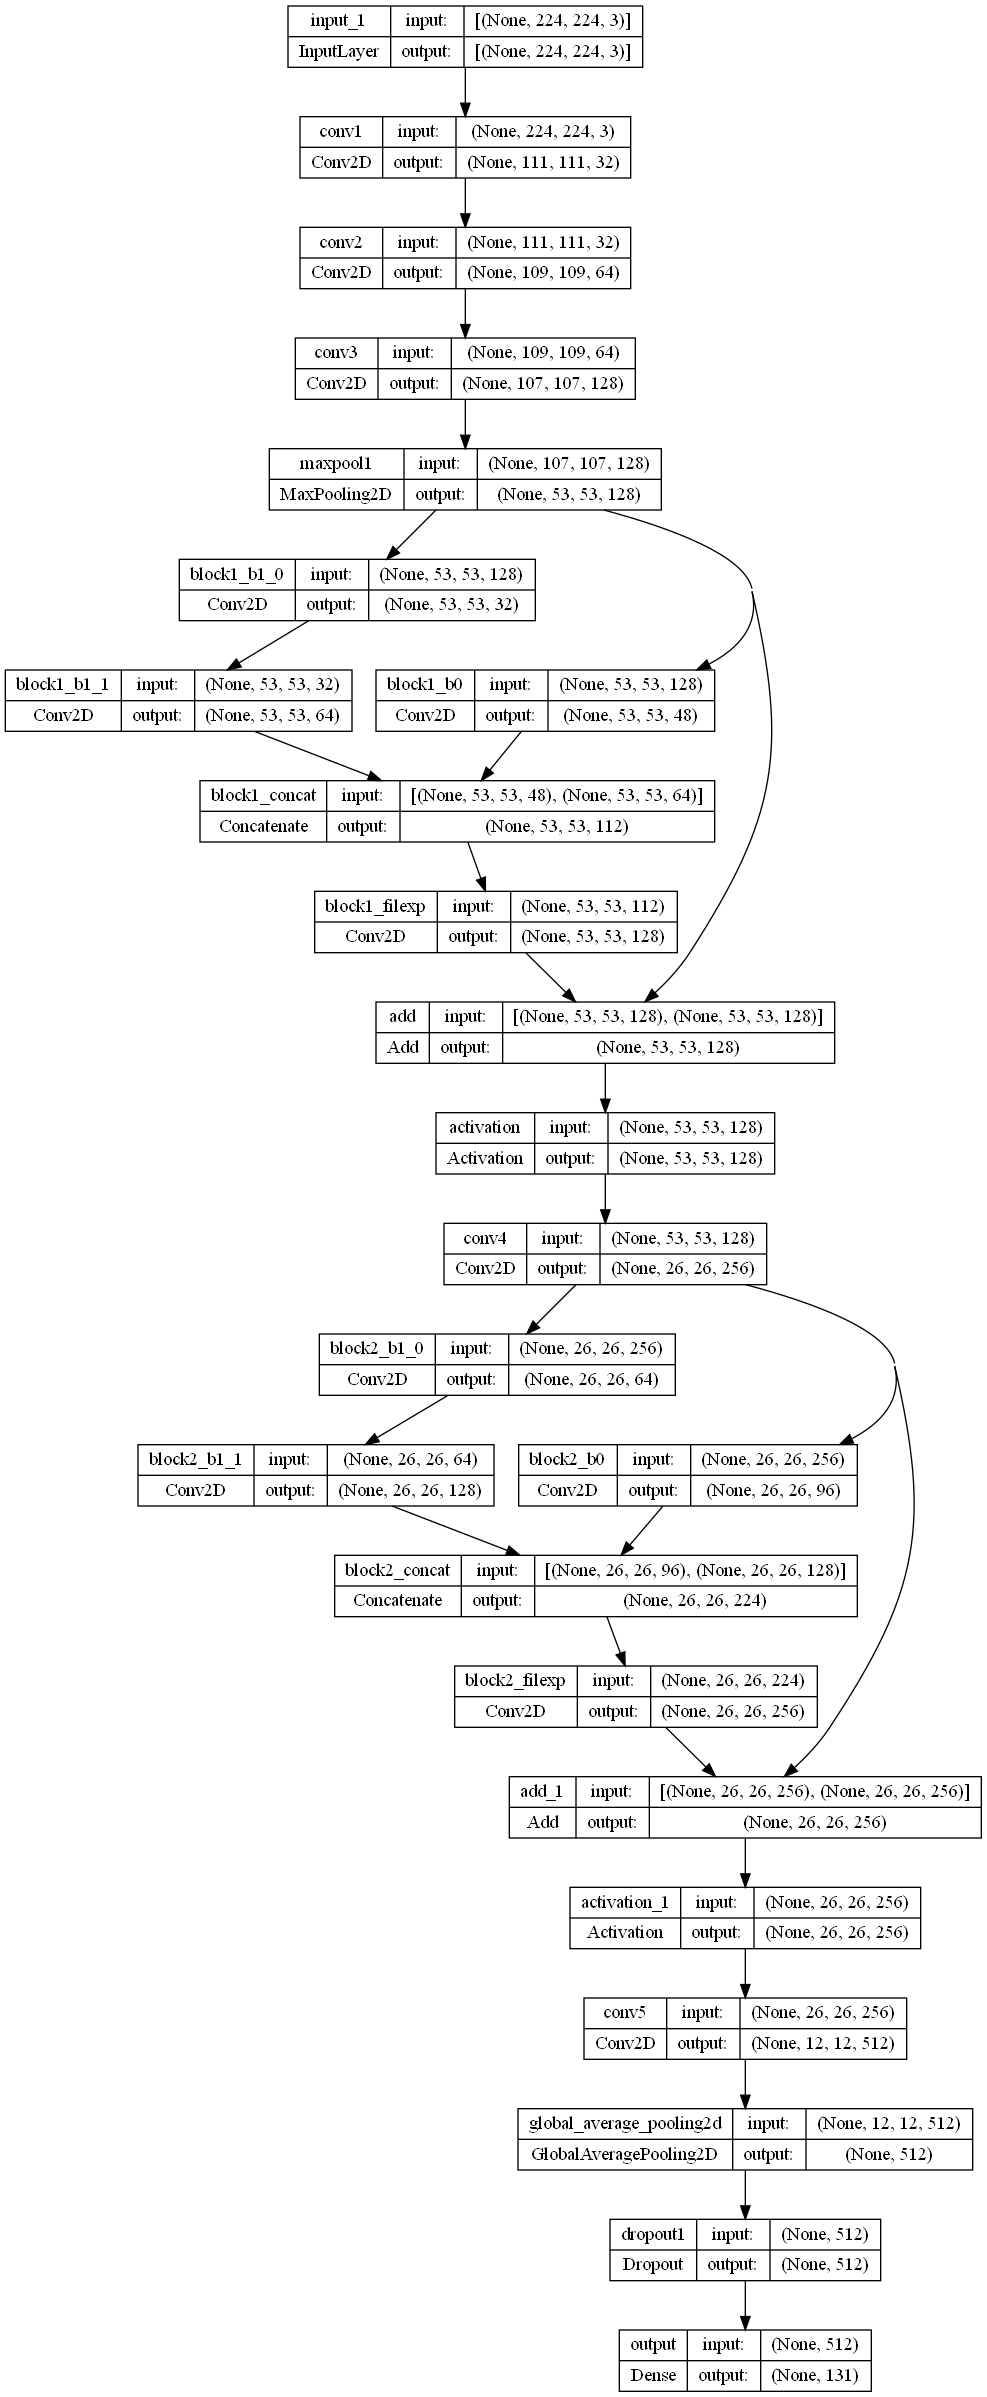

In [12]:
# Plotting custom model's architecture
plot_model(model_custom, to_file='model.png', show_shapes=True, show_layer_names=True)

In [13]:
# Creating callbacks
log_dir = "logs/Custom_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_callback = ModelCheckpoint('custom_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping_callback = EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)

callbacks = [tensorboard_callback, checkpoint_callback, earlystopping_callback]

In [14]:
# Custom model learning
history_custom = model_custom.fit(train_gen, validation_data=validation_gen, epochs=25, callbacks=callbacks)

Epoch 1/25
1694/1694 [==============================] - ETA: 0s - loss: 1.4361 - accuracy: 0.5905
Epoch 1: val_accuracy improved from -inf to 0.90927, saving model to custom_model.h5
1694/1694 [==============================] - 497s 291ms/step - loss: 1.4361 - accuracy: 0.5905 - val_loss: 0.2929 - val_accuracy: 0.9093
Epoch 2/25
1694/1694 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.9286
Epoch 2: val_accuracy improved from 0.90927 to 0.93401, saving model to custom_model.h5
1694/1694 [==============================] - 498s 294ms/step - loss: 0.2151 - accuracy: 0.9286 - val_loss: 0.2813 - val_accuracy: 0.9340
Epoch 3/25
1694/1694 [==============================] - ETA: 0s - loss: 0.1330 - accuracy: 0.9562
Epoch 3: val_accuracy improved from 0.93401 to 0.95719, saving model to custom_model.h5
1694/1694 [==============================] - 496s 292ms/step - loss: 0.1330 - accuracy: 0.9562 - val_loss: 0.1498 - val_accuracy: 0.9572
Epoch 4/25
1694/1694 [============

In [15]:
# Loading of the best weights achieved
model_custom.load_weights('custom_model.h5')

In [16]:
# Custom model evaluation
loss_custom, accuracy_custom = model_custom.evaluate(test_gen)

709/709 [==============================] - 33s 47ms/step - loss: 0.1433 - accuracy: 0.9723


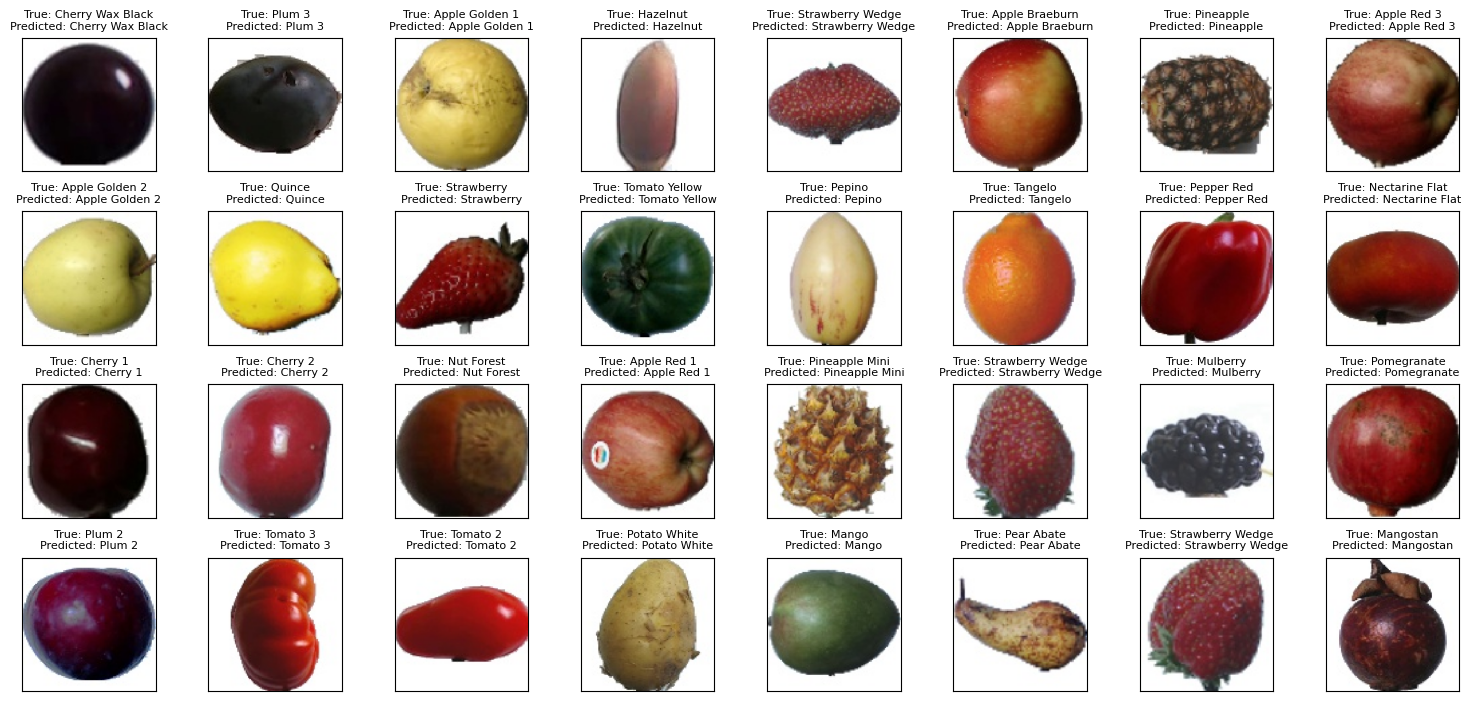

In [19]:
# Plotting a sample of images with predicted and true labels
test_datagen.preprocessing_function = None
X_sample, y_sample = test_gen.next()
X_orig = np.copy(X_sample)

predictions_custom = model_custom.predict(custom_preprocess(X_sample), verbose=0)

predictions_custom = [label_list[np.argmax(prediction)] for prediction in predictions_custom]
true_labels_custom = [label_list[np.argmax(sample)] for sample in y_sample]

fig, axes = plt.subplots(4, 8, figsize=(15, 7), subplot_kw={'xticks' : [], 'yticks' : []})
for i, ax in enumerate(axes.flat):
    ax.imshow(X_orig[i]/255.)
    ax.set_title(f'True: {true_labels_custom[i]}\nPredicted: {predictions_custom[i]}', fontsize=8)
plt.tight_layout(pad=0.5)
plt.show()

In [18]:
loss_acc_df = pd.DataFrame([[loss_custom, accuracy_custom]],
                           columns=["Loss", "Accuracy"],
                           index=["Custom model"])

loss_acc_df

,Loss,Accuracy
Custom model,0.143338,0.97232
